In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
BASE_DIR = "/Users/akshatha/GeorgakopoulosSoaresLab/g4_analysis"
SPECIES_DATA = f"{BASE_DIR}/results/species_data.csv"
G4_PATH = f"{BASE_DIR}/results/g4hunter_g4_distribution.csv"

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

In [4]:
# read species data
df_species = pd.read_csv(f"{BASE_DIR}/results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "GC Percentage", "Taxa"]]
df_species = df_species.replace('na', np.nan)
df_species["GC Percentage"] = df_species["GC Percentage"].astype(float)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.head()

,Accession,Genome Size,GC Percentage,Taxa,Domain
0,GCA_000002515.1,10689156.0,38.5,fungi,Eukaryota
1,GCA_031844645.1,6733472.0,61.0,bacteria,Bacteria
2,GCA_958295725.1,3665566.0,67.0,bacteria,Bacteria
3,GCA_000002765.3,23292622.0,19.0,protozoa,Eukaryota
4,GCA_000006645.1,4701745.0,47.5,bacteria,Bacteria


In [5]:
# read g4 data
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count", "total_g4_length"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
df_g4["total_g4_length"] = df_g4["total_g4_length"].astype(float)
# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
df_g4["GC Corrected G4 Density (per Mb)"] = df_g4["G4 Density (per Mb)"] / (df_g4["GC Percentage"] / 50)
df_g4.head()

# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_g4 = df_g4[df_g4["Taxa"] != "metagenomes"]
df_g4 = df_g4[df_g4["Taxa"] != "other"]

In [12]:
# group by domain
df_g4_grouped = df_g4.groupby("Domain").agg({
	"G4 Density (per Mb)": "mean",
	"GC Corrected G4 Density (per Mb)": "mean"
}).reset_index()
df_g4_grouped.head()

,Domain,Mean G4 Density (per Mb),Min G4 Density (per Mb),Max G4 Density (per Mb),Mean GC Corrected G4 Density (per Mb),Min GC Corrected G4 Density (per Mb),Max GC Corrected G4 Density (per Mb)
0,Archaea,201.315240,3.683517,1939.907098,185.758384,5.416937,1450.360291
1,Bacteria,147.813023,0.000000,4573.717304,127.761355,0.000000,3338.479784
2,Eukaryota,327.031440,7.372880,3054.373410,342.565419,10.532686,2092.036582
3,Virus,262.539348,0.000000,7403.490217,255.847799,0.000000,5803.596211


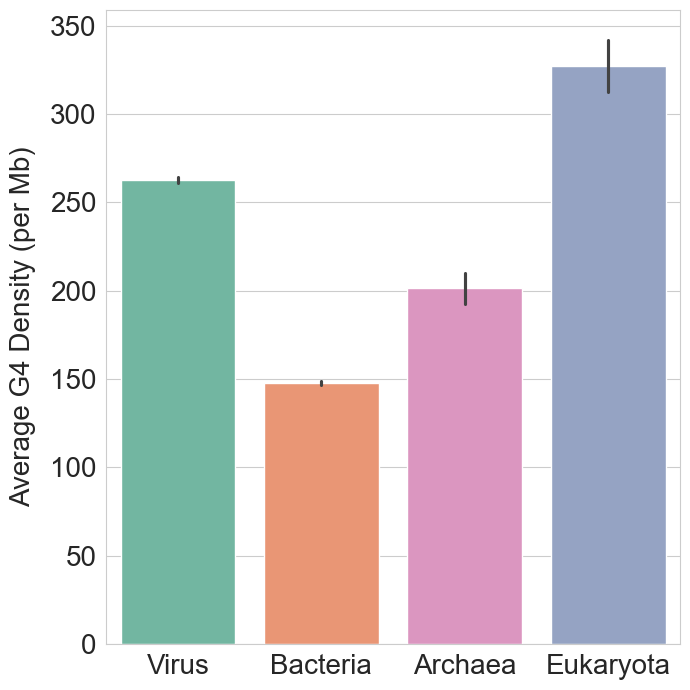

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))

# add standard error bars
sns.barplot(
    x="Domain",
    y="G4 Density (per Mb)",
    data=df_g4,
    hue="Domain",
    palette=color_map,
    order=["Virus", "Bacteria", "Archaea", "Eukaryota"],
    errorbar='se'
)

# formatting
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("")
plt.ylabel("Average G4 Density (per Mb)", fontsize=20, labelpad=10)
plt.tight_layout()

plt.savefig(f"{BASE_DIR}/plots/g4_density_domain_g4hunter.png")

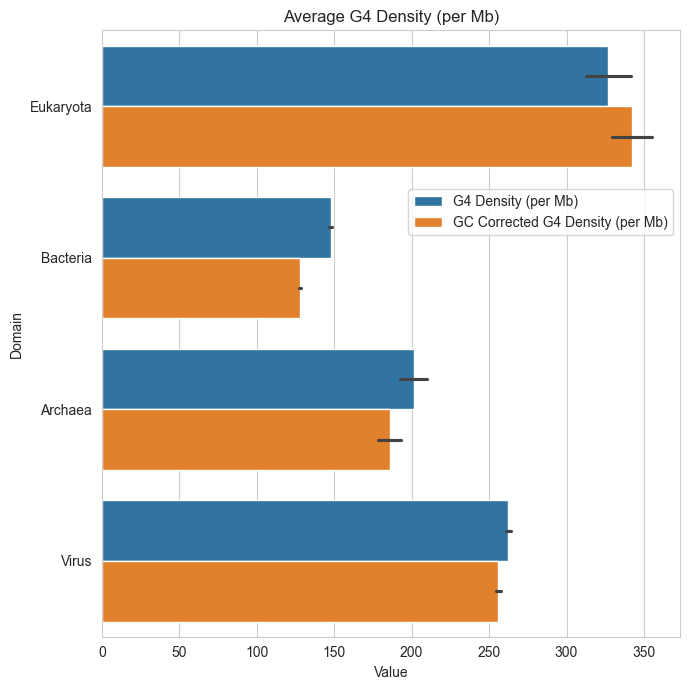

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))
df = df_g4[["Domain", "G4 Density (per Mb)", "GC Corrected G4 Density (per Mb)"]]
tidy = df.melt(id_vars='Domain').rename(columns=str.title)
sns.barplot(
    x="Value", 
    y="Domain", 
    hue='Variable',
    data=tidy,
    errorbar='se'
)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.7))
plt.title("Average G4 Density (per Mb)")
plt.tight_layout()
# plt.savefig(f"{BASE_DIR}/plots/g4_density_domain_gc_corrected_g4hunter.png", dpi=300)